In [1]:
import pandas as pd
import numpy as np

# 자료 불러오기

In [173]:
자산총계 = pd.read_csv("./data/자산총계_최종.csv", index_col=0, dtype={'corp_code':'str', 'stock_code':'str'})
부채총계 = pd.read_csv("./data/부채총계_최종.csv", index_col=0, dtype={'corp_code':'str', 'stock_code':'str'})
자본총계 = pd.read_csv("./data/자본총계_최종.csv", index_col = 0, dtype = {'corp_code':'str', 'stock_code':'str'})
시가총액 = pd.read_csv("./kdigitalProject/data/시가총액_연평균.csv")
LEV = pd.read_csv("./data/LEV.csv", index_col=0, dtype={'corp_code':'str', 'stock_code':'str'})

# LEV, SIZE 변수 만들기

In [174]:
LEV = pd.DataFrame()
for name in 자산총계['corp_name']:
    na_cnt =  자산총계[자산총계.corp_name == name].isnull().sum(axis=1).values[0]
    
    if na_cnt == 0:
        lev = 부채총계[부채총계.corp_name == name].iloc[:, 4:].values / 자산총계[자산총계.corp_name == name].iloc[:, 4:].values
        lev = pd.DataFrame(lev, columns = 자산총계.columns[4:])
    else:
        lev = 부채총계[부채총계.corp_name == name].iloc[:, 4:-na_cnt].values / 자산총계[자산총계.corp_name == name].iloc[:, 4:-na_cnt].values
        lev = pd.DataFrame(lev, columns = 자산총계.columns[4:-na_cnt])
        
    lev.insert(0, '종목명', name)
    LEV = pd.concat([LEV, lev])
LEV.reset_index(drop=True, inplace=True)

In [183]:
LEV_df = pd.DataFrame()
for i in LEV.columns[2:]:
    lev = LEV[['종목명', i]]
    lev.columns = ['종목명', 'LEV']
    lev['연도'] = i
    LEV_df = pd.concat([LEV_df, lev])

In [185]:
SIZE = np.log(자산총계.iloc[:, 4:])
SIZE = pd.concat([자산총계[['corp_name', 'stock_code']], SIZE], axis=1)

In [187]:
SIZE = np.log(자산총계.iloc[:, 4:])
SIZE = pd.concat([자산총계[['corp_name', 'stock_code']], SIZE], axis=1)
SIZE_df = pd.DataFrame()
for i in SIZE.columns[2:]:
    size = SIZE[['stock_code', 'corp_name', i]]
    size.columns = ['기업코드', '종목명', 'SIZE']
    size['연도'] = i
    SIZE_df = pd.concat([SIZE_df, size])

# 전처리

In [194]:
data = pd.read_csv("./kdigitalProject/data/최종데이터_ESG환산.csv", index_col=0)

In [195]:
data = data.replace("A+", 6).replace("A", 5).replace("B+", 4).replace("B", 3).replace("C", 2).replace("D", 1).replace("E", np.NaN)

In [196]:
# print(data.dtypes)
# print(LEV_df.dtypes)
LEV_df['연도'] = LEV_df['연도'].astype('int')
SIZE_df['연도'] = SIZE_df['연도'].astype('int')

In [197]:
data = pd.merge(data, LEV_df[['종목명', '연도', 'LEV']], on=['종목명', '연도'])
data = pd.merge(data, SIZE_df[['종목명', '연도', 'SIZE']], on=['종목명', '연도'])

In [199]:
data.dropna(axis=0, inplace=True)
data = data[data['누적수익률'] != 'np.NAN']
data['누적수익률'] = data['누적수익률'].astype('float')

# 상관계수

In [200]:
import warnings 
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt 
import seaborn as sns

plt.rcParams['font.family'] = 'NanumGothic'

<AxesSubplot:>

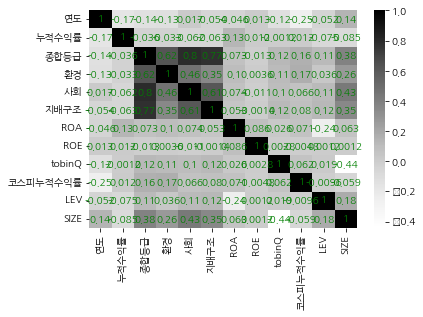

In [201]:
sns.heatmap(data.corr(), annot=True, annot_kws=dict(color='g'), cmap='Greys')

# 회귀분석

In [202]:
X = data[['종합등급', '코스피누적수익률', '연도', 'LEV', 'SIZE', 'ROE']]
y = data['ROA']

In [203]:
import statsmodels.api as sm 
results = sm.OLS(y, sm.add_constant(X)).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ROA   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     75.05
Date:                Wed, 11 May 2022   Prob (F-statistic):           1.02e-89
Time:                        16:37:43   Log-Likelihood:                -17701.
No. Observations:                4648   AIC:                         3.542e+04
Df Residuals:                    4641   BIC:                         3.546e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        467.9738    127.093      3.682      0.000     218.810     717.137
종합등급           0.8092      0.259      3.123      0.002       0.301       1.317
코스피누적수익률       0.0723      0.020      3.615      0.000       0.033       0.111
연도            -0.2377      0.063     -3.761      0.000      -0.362      -0.114
LEV          -14.5117      0.776    -18.698      0.000     -16.033     -12.990
SIZE           0.6405      0.098      6.567      0.000       0.449       0.832
ROE            0.0047      0.001      6.301      0.000       0.003       0.006
==============================================================================
Omnibus:                     8881.100   Durbin-Watson:                   1.687
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         42743703.195
Skew:                          14.226   Prob(JB):                         0.00
Kurtosis:                     471.933   Cond. No.                     1.60e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [204]:
X = data[['종합등급', '코스피누적수익률', '연도', 'LEV', 'SIZE', 'ROE']]
y = data['tobinQ']

In [205]:
import statsmodels.api as sm 
results = sm.OLS(y, sm.add_constant(X)).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 tobinQ   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     336.7
Date:                Wed, 11 May 2022   Prob (F-statistic):               0.00
Time:                        16:38:11   Log-Likelihood:                -60303.
No. Observations:                4648   AIC:                         1.206e+05
Df Residuals:                    4641   BIC:                         1.207e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.789e+05   1.22e+06      0.312      0.755      -2e+06    2.76e+06
종합등급        6.229e+04   2477.860     25.139      0.000    5.74e+04    6.71e+04
코스피누적수익률    -373.6173    191.252     -1.954      0.051    -748.562       1.327
연도           244.0570    604.422      0.404      0.686    -940.897    1429.011
LEV         5.091e+04   7422.232      6.860      0.000    3.64e+04    6.55e+04
SIZE       -3.996e+04    932.756    -42.842      0.000   -4.18e+04   -3.81e+04
ROE            4.5405      7.168      0.633      0.526      -9.512      18.593
==============================================================================
Omnibus:                     8069.758   Durbin-Watson:                   1.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          9531999.902
Skew:                          12.049   Prob(JB):                         0.00
Kurtosis:                     223.540   Cond. No.                     1.60e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""